[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/florpi/heidelberg_generative_lectures/blob/main/1_box_muller.ipynb)

In [ ]:
!pip install numpy matplotlib scipy torch


# The Box-Muller Transform

## Why This Matters for Generative Models

In generative modeling, we often need to transform simple distributions (like uniform or standard normal) into complex ones that represent our data. The Box-Muller transform, developed by George Box and Mervin Muller in 1934, is one of the earliest and most elegant examples of such transformations. More importantly, it serves as a perfect introduction to the mathematical principles underlying **normalizing flows** - a powerful class of generative models that learn to transform simple distributions into complex ones.

By the end of this tutorial, you will understand:

1. **The fundamental problem**: How to generate samples from more complex distributions using simple ones
2. **The mathematical foundation**: The change of variables rule and its role in probability transformations
3. **Practical implementation**: How to implement such transformations using automatic differentiation methods

## The Box-Muller Transform

The Box-Muller transform converts two independent uniform random variables into two independent standard normal random variables. Given $U_1, U_2 \sim \text{Uniform}(0,1)$, the transformation:

$$Z_0 = \sqrt{-2 \ln U_1} \cos(2\pi U_2)$$
$$Z_1 = \sqrt{-2 \ln U_1} \sin(2\pi U_2)$$

produces $Z_0, Z_1 \sim \mathcal{N}(0,1)$.

In esence it is an invertible, differentiable transformations that can reshape probability distributions while maintaining tractable densities.

Let's explore this step by step!

## Implementation: 

Let's implement the Box-Muller transform and verify that it works as expected. 


In [1]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

In [2]:

def box_muller_transform(u1, u2):
    """
    Box-Muller transform: (u1, u2) -> (z1, z2)
    where u1, u2 ~ Uniform(0,1) and z1, z2 ~ Normal(0,1)
    """
    #TODO: Implement the Box-Muller transform

    z1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    z2 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
    return z1, z2


In [3]:
# sample from 2d uniform distribution

u1 = np.random.uniform(0, 1, 2_000)
u2 = np.random.uniform(0, 1, 2_000)

# transform to normal distribution
z1, z2 = box_muller_transform(u1, u2)


Text(0.5, 1.0, '$Z_1, Z_2 \\sim \\mathcal{N}(0,1)$')

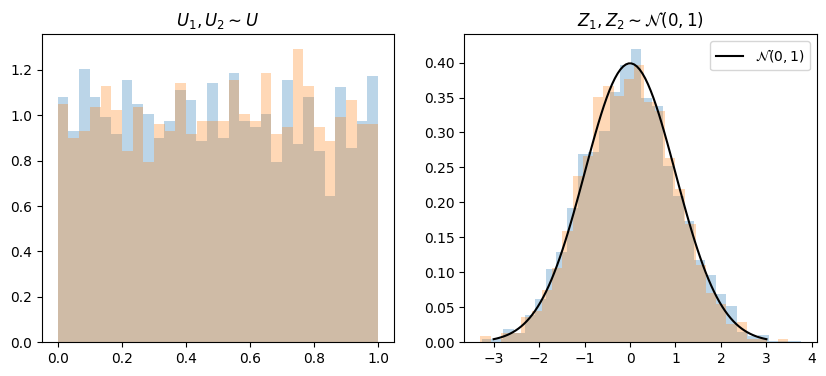

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
_ = ax[0].hist(u1, bins=30, density=True, alpha=0.3,)
_ = ax[0].hist(u2, bins=30, density=True, alpha=0.3,)
_ = ax[1].hist(z1, bins=30, density=True, alpha=0.3,)
_ = ax[1].hist(z2, bins=30, density=True, alpha=0.3,)

x_plot = np.linspace(-3, 3, 100)

ax[1].plot(
    x_plot,
    norm.pdf(x_plot),
    label=r"$\mathcal{N}(0, 1)$",
    c='k',
)
ax[1].legend()

ax[0].set_title(r'$U_1, U_2 \sim U$')
ax[1].set_title(r'$Z_1, Z_2 \sim \mathcal{N}(0,1)$')

## The Change of Variables Rule 

The beauty of the Box-Muller transform lies not just in its simplicity, but in how it demonstrates the **change of variables rule** for byjective functions - the foundation of normalizing flows.

### The Change of Variables Rule 

When we transform random variables using a differentiable, **invertible** function $f: u \rightarrow z$, the probability density changes according to:

$$p_Z(z) = p_U(u=f^{-1}(z)) \left| \frac{\partial f^{-1}(z)}{\partial z} \right|$$

Where:
- $p_Z(z)$ is the density of the transformed variable
- $p_U(u)$ is the density of the original variable  
- $f^{-1}$ is the inverse transformation
- $\left| \frac{\partial f^{-1}(z)}{\partial z} \right|$ is the absolute value of the Jacobian determinant

### Why This Matters for Normalizing Flows

In normalizing flows, we:
1. **Learn** the transformation $f_\theta$ (instead of using a fixed one like Box-Muller)
2. **Compute** the Jacobian determinant efficiently using automatic differentiation
3. **Use** this to compute exact likelihoods for training

Let's verify that Box-Muller satisfies this theorem!

In [5]:
# TODO: Compute the Jacobian of the transformation
def analytical_jacobian_determinant(z1, z2):
    r_squared = z1**2 + z2**2
    u1 = np.exp(-0.5 * r_squared)
    
    du1_dz1 = -z1 * u1
    du1_dz2 = -z2 * u1
    du2_dz1 = -z2 / (2 * np.pi * r_squared)
    du2_dz2 = z1 / (2 * np.pi * r_squared)
    
    return du1_dz1 * du2_dz2 - du1_dz2 * du2_dz1

# TODO: Compute the transformed PDF
def compute_transformed_pdf(z1, z2, u1, u2):
    uniform_pdf = 1.0
    jac_det = analytical_jacobian_determinant(z1, z2)
    return uniform_pdf * np.abs(jac_det)


pdf_jacobian = compute_transformed_pdf(z1, z2, u1, u2)
pdf_analytical = multivariate_normal.pdf(np.column_stack((z1, z2)), mean=[0, 0], cov=[[1, 0], [0, 1]])


Text(0, 0.5, 'PDF')

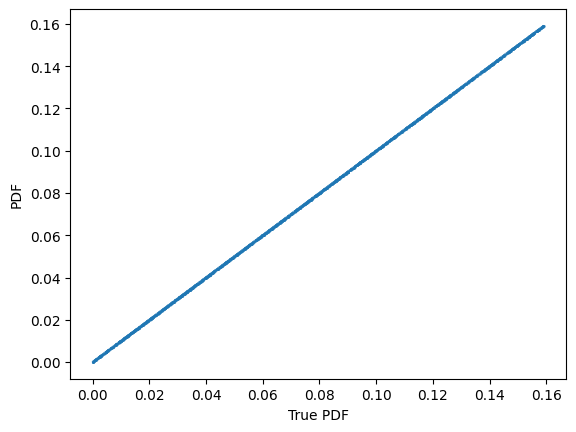

In [6]:
plt.plot(pdf_analytical, pdf_jacobian, marker='o', alpha=0.6, markersize=1,)
plt.xlabel('True PDF')
plt.ylabel('PDF')

## Automatic Differentiation

As you've learned, manually computing Jacobians becomes impractical for complex transformations. This is where **automatic differentiation** becomes crucial.

### Why Automatic Differentiation?

1. **Scalability**: Hand-deriving Jacobians for complex neural networks is impossible
2. **Efficiency**: Autodiff computes exact derivatives in the same time as forward pass
3. **Flexibility**: We can easily change architectures without re-deriving derivatives
4. **Numerical Stability**: Avoids approximation errors from numerical differentiation


Let's implement the autodiff equivalent using PyTorch!

In [7]:
import torch

# Device setup - automatically detect and use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# TODO: Write the inverse Box-Muller transform and use autodiff to compute the Jacobia
def inverse_box_muller(z):
    """
    Inverse Box-Muller: (z1, z2) -> (u1, u2)
    """
    z1, z2 = z[..., 0], z[..., 1]
    
    r_squared = z1**2 + z2**2
    theta = torch.atan2(z2, z1)
    
    u1 = torch.exp(-0.5 * r_squared)
    u2 = theta / (2 * torch.pi)
    
    u2 = torch.where(u2 < 0, u2 + 1.0, u2)
    return torch.stack([u1, u2], dim=-1)

def compute_jacobian_autograd(func, inputs):

    """
    Compute Jacobian using PyTorch's autograd.
    For a function f: R^n -> R^m, computes the m x n Jacobian matrix.
    """
    inputs = inputs.clone().detach().requires_grad_(True)
    outputs = func(inputs)
    
    jacobian = []
    for i in range(outputs.shape[-1]):  # For each output dimension
        grad_outputs = torch.zeros_like(outputs)
        grad_outputs[..., i] = 1.0
        
        grad_inputs = torch.autograd.grad(
            outputs=outputs,
            inputs=inputs,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True
        )[0]
        
        jacobian.append(grad_inputs)
    
    return torch.stack(jacobian, dim=-2)

# Convert NumPy arrays to PyTorch tensors on the correct device
z = torch.tensor(np.column_stack((z1, z2)), dtype=torch.float32, device=device)

autodiff_jacobian = compute_jacobian_autograd(inverse_box_muller, z).detach()
pdf_autodiff = 1.0 * torch.abs(torch.det(autodiff_jacobian))  

Using device: cpu


Text(0, 0.5, 'PDF')

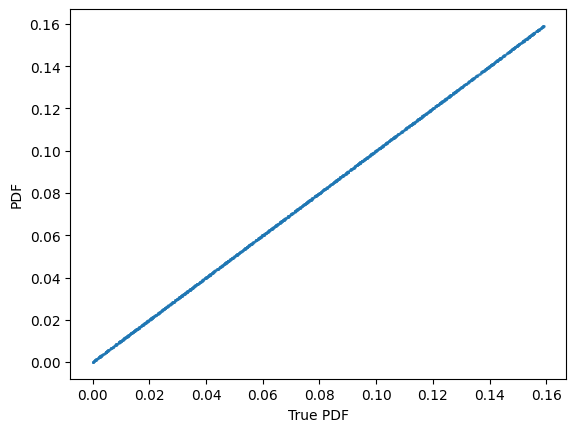

In [8]:
plt.plot(pdf_analytical, pdf_autodiff, marker='o', alpha=0.6, markersize=1, linestyle='')
plt.xlabel('True PDF')
plt.ylabel('PDF')